<a href="https://colab.research.google.com/github/XimenaCantera/MSMGC_ActividadIntegradora/blob/main/RobotCajas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Organización de Almacén con Robots

Este cuaderno describe la implementación de un sistema de robots para organizar un almacén desordenado, apilando cajas en pilas de exactamente cinco. Se detallan la estrategia, los mecanismos utilizados, las visualizaciones del proceso, y una discusión sobre posibles mejoras.

## Estrategia y Mecanismos Utilizados

### Descripción General

Cada robot está equipado con ruedas omnidireccionales y sensores que les permiten identificar el estado de las celdas adyacentes (vacías, con paredes, con cajas o con otros robots). Los robots pueden recoger cajas de celdas adyacentes y apilarlas en otras ubicaciones hasta un máximo de cinco cajas por pila.

### Algoritmo de Movimiento y Recolección

1. **Inicialización**:
   - El almacén de tamaño 20x20 se llena con 200 cajas distribuidas aleatoriamente en pilas de 1 a 3 cajas.
   - Se colocan 5 robots en posiciones aleatorias del almacén, asegurándose de que no haya dos robots en la misma celda.

2. **Sensado del Entorno**:
   - Cada robot puede detectar el estado de las celdas adyacentes para decidir su movimiento.

3. **Movimiento y Recolección**:
   - Los robots buscan la pila de cajas más cercana que no haya alcanzado la altura objetivo (5 cajas).
   - Se mueven hacia las cajas, recogen una caja y luego buscan una pila parcial donde dejarla.

4. **Evitación de Conflictos**:
   - Los robots evitan moverse a celdas ocupadas por otros robots o paredes.

### Verificación del Estado del Almacén

La simulación se ejecuta hasta que todas las cajas estén correctamente apiladas en pilas de exactamente cinco. Se verifica continuamente el estado del almacén para determinar si se ha alcanzado la condición de término.

### Visualización

Se generan visualizaciones del estado del almacén cada 50 pasos para observar el progreso de la simulación.

## Implementación del Código

Estado inicial del almacén:
[[0 3 2 0 0 0 0 0 0 0 1 0 2 2 0 0 3 0 0 0]
 [0 3 0 2 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 3 0 0 0 2 0 0 0 3 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 2 0 2 0 0 0 1 1]
 [0 0 0 0 0 0 1 0 1 2 0 0 0 1 0 0 0 0 3 0]
 [1 0 0 0 0 0 0 0 0 2 1 0 0 0 1 2 2 0 0 0]
 [0 0 0 0 0 0 2 0 0 0 0 3 2 0 0 0 0 3 0 0]
 [0 1 0 0 3 0 0 0 0 0 0 0 0 0 0 3 3 0 0 3]
 [3 0 0 3 0 0 0 3 1 0 0 0 0 0 0 0 3 0 0 3]
 [2 3 0 0 0 0 2 0 0 1 0 0 0 0 0 0 1 0 2 0]
 [0 1 0 0 0 0 0 0 2 1 1 0 0 2 0 0 0 0 0 0]
 [0 3 0 0 0 2 0 0 0 0 0 3 0 0 0 3 0 0 0 0]
 [0 0 2 0 0 0 0 0 1 0 0 3 1 0 0 0 0 0 1 0]
 [0 2 0 0 0 0 3 3 0 0 0 0 0 3 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 2 1 0 0 1 1 2 0 1 0 0]
 [0 0 1 0 0 0 0 1 0 0 2 0 0 0 0 2 0 0 2 0]
 [0 2 0 0 0 1 0 3 0 0 3 0 0 1 1 0 0 0 0 3]
 [0 0 0 0 0 0 0 2 1 1 0 0 0 0 0 0 0 0 1 2]
 [0 2 0 0 0 0 3 1 0 0 0 0 0 0 0 1 0 0 3 0]
 [0 0 0 1 0 0 2 0 3 0 2 0 0 0 3 1 0 0 0 0]]
Posiciones iniciales de los robots:
[(9, 2), (6, 19), (2, 3), (14, 4), (16, 9)]


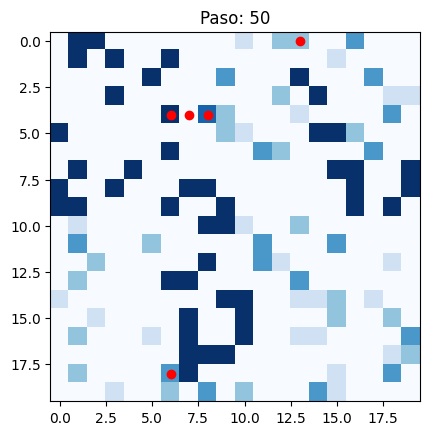

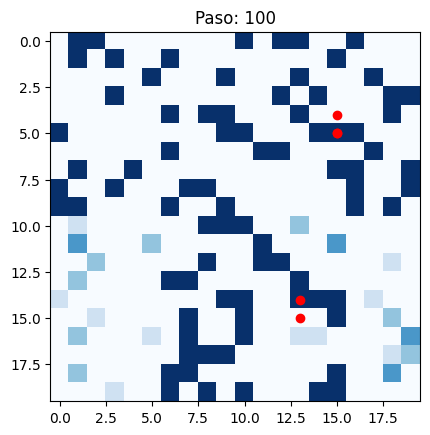

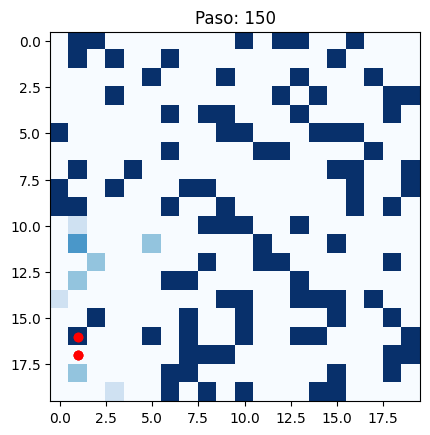

Simulación completada en 184 pasos.


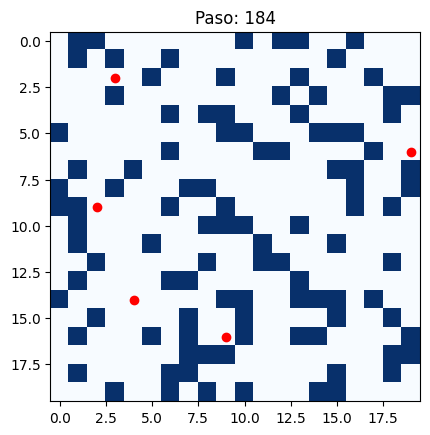

Estado final del almacén:
[[0 5 5 0 0 0 0 0 0 0 5 0 5 5 0 0 5 0 0 0]
 [0 5 0 5 0 0 5 0 0 0 0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 5 0 0 0 5 0 0 0 5 0 0]
 [0 0 0 5 0 0 0 0 0 0 0 0 5 0 5 0 0 0 5 5]
 [0 0 0 0 0 0 5 0 5 5 0 0 0 5 0 0 0 0 5 0]
 [5 0 0 0 0 0 0 0 0 5 5 0 0 0 5 5 5 0 0 0]
 [0 0 0 0 0 0 5 0 0 0 0 5 5 0 0 0 0 5 0 0]
 [0 5 0 0 5 0 0 0 0 0 0 0 0 0 0 5 5 0 0 5]
 [5 0 0 5 0 0 0 5 5 0 0 0 0 0 0 0 5 0 0 5]
 [5 5 0 0 0 0 5 0 0 5 0 0 0 0 0 0 5 0 5 0]
 [0 5 0 0 0 0 0 0 5 5 5 0 0 5 0 0 0 0 0 0]
 [0 5 0 0 0 5 0 0 0 0 0 5 0 0 0 5 0 0 0 0]
 [0 0 5 0 0 0 0 0 5 0 0 5 5 0 0 0 0 0 5 0]
 [0 5 0 0 0 0 5 5 0 0 0 0 0 5 0 0 0 0 0 0]
 [5 0 0 0 0 0 0 0 0 5 5 0 0 5 5 5 0 5 0 0]
 [0 0 5 0 0 0 0 5 0 0 5 0 0 0 0 5 0 0 5 0]
 [0 5 0 0 0 5 0 5 0 0 5 0 0 5 5 0 0 0 0 5]
 [0 0 0 0 0 0 0 5 5 5 0 0 0 0 0 0 0 0 5 5]
 [0 5 0 0 0 0 5 5 0 0 0 0 0 0 0 5 0 0 5 0]
 [0 0 0 5 0 0 5 0 5 0 5 0 0 0 5 5 0 0 0 0]]
Todas las cajas están apiladas en 5 pilas.


In [17]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Semilla para la generación de números aleatorios
random.seed(67890)
np.random.seed(67890)

# Constantes
WAREHOUSE_SIZE = 20
NUM_BOXES = 200
NUM_ROBOTS = 5
MAX_BOX_STACK = 3
TARGET_STACK_HEIGHT = 5

# Inicialización del almacén (0: vacío, -1: pared, 1-5: número de cajas en la pila)
warehouse = np.zeros((WAREHOUSE_SIZE, WAREHOUSE_SIZE), dtype=int)

def place_initial_boxes(warehouse, num_boxes, max_box_stack):
    remaining_boxes = num_boxes
    while remaining_boxes > 0:
        stack_height = min(random.randint(1, max_box_stack), remaining_boxes)
        x, y = random.randint(0, WAREHOUSE_SIZE-1), random.randint(0, WAREHOUSE_SIZE-1)
        if warehouse[x, y] == 0:
            warehouse[x, y] = stack_height
            remaining_boxes -= stack_height

place_initial_boxes(warehouse, NUM_BOXES, MAX_BOX_STACK)
print("Estado inicial del almacén:")
print(warehouse)

robots = []

def place_robots(warehouse, num_robots):
    while len(robots) < num_robots:
        x, y = random.randint(0, WAREHOUSE_SIZE-1), random.randint(0, WAREHOUSE_SIZE-1)
        if warehouse[x, y] == 0 and (x, y) not in robots:
            robots.append((x, y))

place_robots(warehouse, NUM_ROBOTS)
print("Posiciones iniciales de los robots:")
print(robots)

def move_robot(robot, direction):
    x, y = robot
    if direction == 'up' and x > 0:
        x -= 1
    elif direction == 'down' and x < WAREHOUSE_SIZE - 1:
        x += 1
    elif direction == 'left' and y > 0:
        y -= 1
    elif direction == 'right' and y < WAREHOUSE_SIZE - 1:
        y += 1
    return (x, y)

def get_adjacent_cells(robot):
    x, y = robot
    cells = {
        'up': (x-1, y) if x > 0 else None,
        'down': (x+1, y) if x < WAREHOUSE_SIZE - 1 else None,
        'left': (x, y-1) if y > 0 else None,
        'right': (x, y+1) if y < WAREHOUSE_SIZE - 1 else None
    }
    return cells

def sense_environment(robot, warehouse):
    cells = get_adjacent_cells(robot)
    sensed = {}
    for direction, cell in cells.items():
        if cell is None:
            sensed[direction] = 'wall'
        else:
            x, y = cell
            if warehouse[x, y] == -1:
                sensed[direction] = 'wall'
            elif warehouse[x, y] == 0:
                sensed[direction] = 'empty'
            elif 1 <= warehouse[x, y] <= 5:
                sensed[direction] = f'boxes_{warehouse[x, y]}'
            elif cell in robots:
                sensed[direction] = 'robot'
    return sensed

def pick_up_box(robot, warehouse):
    x, y = robot
    if warehouse[x, y] > 0:
        warehouse[x, y] -= 1
        return True
    return False

def drop_box(robot, warehouse):
    x, y = robot
    if warehouse[x, y] < TARGET_STACK_HEIGHT:
        warehouse[x, y] += 1
        return True
    return False

def find_nearest_box(robot, warehouse):
    x, y = robot
    min_distance = float('inf')
    target = None
    for i in range(WAREHOUSE_SIZE):
        for j in range(WAREHOUSE_SIZE):
            if 1 <= warehouse[i, j] < TARGET_STACK_HEIGHT:
                distance = abs(x - i) + abs(y - j)
                if distance < min_distance:
                    min_distance = distance
                    target = (i, j)
    return target

def robot_strategy(robot, warehouse, carrying_box):
    if carrying_box:
        # Avanza hacia una pila que pueda aceptar más cajas (<5).
        target = find_nearest_box(robot, warehouse)
        if target:
            target_x, target_y = target
            if robot == target:
                return robot, drop_box(robot, warehouse)
            if robot[0] < target_x:
                return move_robot(robot, 'down'), carrying_box
            elif robot[0] > target_x:
                return move_robot(robot, 'up'), carrying_box
            elif robot[1] < target_y:
                return move_robot(robot, 'right'), carrying_box
            elif robot[1] > target_y:
                return move_robot(robot, 'left'), carrying_box
    else:
        # Avanza hacia una caja para recoger
        target = find_nearest_box(robot, warehouse)
        if target:
            target_x, target_y = target
            if robot == target:
                return robot, pick_up_box(robot, warehouse)
            if robot[0] < target_x:
                return move_robot(robot, 'down'), carrying_box
            elif robot[0] > target_x:
                return move_robot(robot, 'up'), carrying_box
            elif robot[1] < target_y:
                return move_robot(robot, 'right'), carrying_box
            elif robot[1] > target_y:
                return move_robot(robot, 'left'), carrying_box
    return robot, carrying_box

def all_stacks_correct(warehouse):
    return np.all((warehouse == 0) | (warehouse == TARGET_STACK_HEIGHT))

def run_simulation(warehouse, robots, max_steps=1000):
    steps = 0
    carrying_boxes = [False] * len(robots)
    while not all_stacks_correct(warehouse):
        new_positions = []
        for i, robot in enumerate(robots):
            new_pos, carrying_box = robot_strategy(robot, warehouse, carrying_boxes[i])
            carrying_boxes[i] = carrying_box
            new_positions.append(new_pos)
        robots = new_positions
        steps += 1
        if steps % 50 == 0:
            visualize_warehouse(warehouse, robots, steps)
    return steps

def visualize_warehouse(warehouse, robots, step):
    plt.imshow(warehouse, cmap='Blues', vmin=0, vmax=TARGET_STACK_HEIGHT)
    for robot in robots:
        plt.scatter(robot[1], robot[0], c='red')
    plt.title(f'Paso: {step}')
    plt.show()

steps = run_simulation(warehouse, robots)
print(f'Simulación completada en {steps} pasos.')
visualize_warehouse(warehouse, robots, steps)
print("Estado final del almacén:")
print(warehouse)

# Verificación final de las pilas
if all_stacks_correct(warehouse):
    print("Todas las cajas están apiladas en 5 pilas.")
else:
    print("Algunas cajas no están correctamente apiladas.")


# ¿Existe una forma de reducir el número de pasos utilizados?

Una estrategia para reducir el número de pasos utilizados podría ser optimizar el movimiento de los robots para que recorran distancias más cortas mientras recogen y apilan las cajas. Esto implicaría implementar algoritmos de planificación de rutas, como Dijkstra, para que los robots elijan la ruta más corta hacia las cajas y las pilas de cajas. Además, los robots podrían priorizar recoger cajas de pilas que estén más cerca de alcanzar la altura objetivo de 5, minimizando la necesidad de recoger cajas de pilas más pequeñas y reduciendo el número total de movimientos requeridos. También se podría permitir que los robots coordinen sus movimientos para evitar colisiones y optimizar el uso del espacio en el almacén, ya sea mediante la comunicación entre ellos. Por último, el implementar una combinación de estas estrategias podría darnos una reducción en el número de pasos necesarios para completar la simulación, aunque es importante equilibrar la complejidad de las estrategia y la simplicidad de implementación.